In [317]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Approach adapted from https://www.labri.fr/perso/nrougier/from-python-to-numpy/#boids

### Begin with a 2D LJ simulation

This will be a 2-dimensional simulation of Lennard-Jones particles using all dimensionless parameters:
* Time step $t = 1$
* Particle mass $m = 1$
* Temperature $T = 1$
* LJ potential width $\sigma=1$
* LJ potential depth $\epsilon=1$

In [442]:
# Define dimensionless parameters
dt = 1.
m = 1.
kB = 1  # Boltzmann constant
L = 50.  # Simulation box size

In [481]:
# Define simulation settings
n = 16
sigma = 1.
epsilon = 1.
rcut = 5.
assert(rcut < L/2)
dtlog = 10 # Log to trajectory every dtlog time steps

In [482]:
# Initialize positions
pos = np.zeros((n, 2), dtype=np.float32)
nside = int(np.sqrt(n))  # For now, just assume sqrt(n) is integer... deal with general case later
lside = (4./5.) * L  # Shrink initial lattice slightly to avoid overlap of periodic images
x = np.linspace(-lside/2, lside/2, nside)
y = np.linspace(-lside/2, lside/2, nside)
X,Y = np.meshgrid(x,y)
pos_init = np.array([X.flatten(),Y.flatten()]).T
pos += pos_init
pos += np.random.uniform(0, .03*L, pos.shape)  #  Add some noise to break the symmetry}

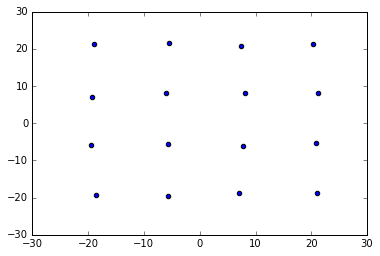

In [483]:
# Visualize uniform initial positions in simulation box
plt.scatter(pos[:,0], pos[:,1])

In [484]:
# Initialize velocities to uniform distribution with zero mean
velocity = np.zeros((n, 2), dtype=np.float32)
velocity += np.random.uniform(-.2, .2, size=(n, 2))  # Uniform random velocities
velocity -= np.mean(velocity) # Subtract the mean (no bulk flow)
# for i in range(velocity.shape[1]):
#     velocity[:,i] /= np.mean(velocity[:,i]**2)  # Scale the velocities to get desired initial temperature

In [485]:
# Determine particles within cutoff radius
dx = np.subtract.outer(pos[:, 0], pos[:, 0])
dy = np.subtract.outer(pos[:, 1], pos[:, 1])

# Apply "minimum image" convention -- particles interact only with nearest periodic image
dx[dx > L/2] -= L
dx[dx < -L/2] += L

dy[dy > L/2] -= L
dy[dy < -L/2] += L

r2 = dx**2 + dy**2  # Squared distance between all pairs of particles

# Select interaction pairs within cutoff distance (also ignore self-interactions)
mask = r2 < rcut**2
mask *= r2 > 0

In [486]:
# Define functions for computing forces and energy
def lj_potential(r2, sigma, epsilon):
    """Compute the Lennard-Jones potential
    
    Parameters
    ----------
    r2 : float or [N] numpy array
        Squared particle-particle separation.
    sigma : float
        Width of the potential, defined by distance at which potential is zero.
    epsilon : float
        Depth of the potential well, relative to the energy at infinite separation.
    
    """
    energy = 4*epsilon*((sigma**2/r2)**6 - (sigma**2/r2)**3)
    return energy

def lj_force(r2, sigma, epsilon):
    """Compute the Lennard-Jones force.
    
    Returned value is normalized by r, such that it can be multiplied by the 
    x, y or z component of r to obtain the correct cartesian component of the 
    force.
    
    Parameters
    ----------
    r2 : float or [N] numpy array
        Squared particle-particle separation.
    sigma : float
        Width of the potential, defined by distance at which potential is zero.
    epsilon : float
        Depth of the potential well, relative to the energy at infinite separation.
    
    """
    force = (48/r2)*epsilon*((sigma**2/r2)**6 - .5*(sigma**2/r2)**3)
    return force

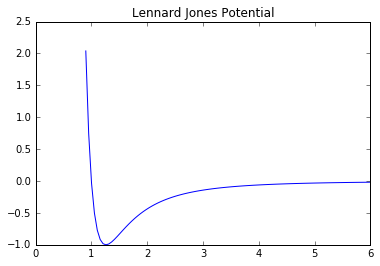

In [487]:
x = np.linspace(.9, 6, 100)
pot = lj_potential(x, 1, 1)
plt.plot(x, pot)
plt.title('Lennard Jones Potential')

In [488]:
# Compute forces and energy
energy = np.sum(lj_potential(r2[mask], sigma, epsilon))
fx = np.zeros_like(dx)
fx[mask] = dx[mask] * lj_force(r2[mask], sigma, epsilon)
fy = np.zeros_like(dy)
fy[mask] = dy[mask] * lj_force(r2[mask], sigma, epsilon)

In [489]:
def apply_pbc(arr, L):
    return ((arr + L/2) % L) - L/2
#     return arr % L

In [490]:
def minimum_image(dx, L):
    dx[dx > L/2] -= L
    dx[dx < -L/2] += L

In [494]:
# Run dynamics
nframes = 10000
dtlog=10
pos_prev = pos - velocity*dt  # Fake the pos at time step before initial pos
pos_next = np.empty_like(pos)
pos_nopbc = np.empty_like(pos)

traj = np.empty((nframes/dtlog, pos.shape[0], pos.shape[1]))
for i in range(nframes):
    # Determine particles within cutoff radius
    dx = np.subtract.outer(pos[:, 0], pos[:, 0])
    dy = np.subtract.outer(pos[:, 1], pos[:, 1])

    # Apply "minimum image" convention -- particles interact only with nearest periodic image
    dx[dx > L/2] -= L
    dx[dx < -L/2] += L
    dy[dy > L/2] -= L
    dy[dy < -L/2] += L
    r2 = dx**2 + dy**2  # Squared distance between all pairs of particles

    # Select interaction pairs within cutoff distance (also ignore self-interactions)
    mask = r2 < rcut**2
    mask *= r2 > 0    

    # Compute forces and energy
    energy = np.sum(lj_potential(r2[mask], sigma, epsilon))
    fx = np.zeros_like(dx)
    fx[mask] = dx[mask] * lj_force(r2[mask], sigma, epsilon)
    fy = np.zeros_like(dy)
    fy[mask] = dy[mask] * lj_force(r2[mask], sigma, epsilon)
    
    # Integrate equations of motion (Verlet)
    if i % dtlog == 0:
        traj[i/dtlog] = pos
    net_fx = np.sum(fx, axis=0)
    net_fy = np.sum(fy, axis=0)
    dx = pos[:,0] - pos_prev[:,0]
    dy = pos[:,1] - pos_prev[:,1]
    minimum_image(dx, L)
    minimum_image(dy, L)
    pos_next[:,0] = apply_pbc(pos[:,0] + dx + net_fx/m*dt**2, L)
    pos_next[:,1] = apply_pbc(pos[:,1] + dy + net_fy/m*dt**2, L)
    if i % dtlog == 0:
        print pos[0,0], pos_prev[0,0], pos[0,0] - pos_prev[0,0]
    pos_prev[:] = pos
    pos[:] = pos_next
    
# PBC issues in integration... would this all be easier if redefining simulation domain to be [0,L] 
# instead of [-L/2, L/2] so I could just use modulo % operation? Just need to sort of use minimum image convention
# in integration as well?

-22.6281 -22.5662 -0.0619564
-23.2502 -23.187 -0.0631638
-24.028 -23.9219 -0.10607
24.4397 24.6159 -0.176189
22.6123 22.7966 -0.184277
20.7696 20.9539 -0.184277
18.9268 19.1111 -0.184277
17.084 17.2683 -0.184277
15.2459 15.428 -0.182106
13.6706 13.7791 -0.108513
13.057 13.1074 -0.0504456
12.5571 12.607 -0.0499573
12.0575 12.1074 -0.0499573
11.5579 11.6079 -0.0499573
11.0583 11.1083 -0.0499573
10.5588 10.6087 -0.0499573
10.0592 10.1091 -0.0499573
9.55962 9.60957 -0.0499573
9.02258 9.0806 -0.0580215
8.42412 8.4842 -0.0600853
7.82327 7.88335 -0.0600853
7.22241 7.2825 -0.0600853
6.62156 6.68164 -0.0600853
6.02071 6.08079 -0.0600853
5.41985 5.47994 -0.0600853
4.819 4.87909 -0.0600853
4.21741 4.27793 -0.0605164
3.45113 3.56672 -0.115591
1.84328 2.01664 -0.173359
0.102013 0.276173 -0.17416
-1.63959 -1.46543 -0.17416
-3.38119 -3.20703 -0.17416
-5.12279 -4.94863 -0.17416
-6.86439 -6.69023 -0.17416
-8.60599 -8.43183 -0.17416
-10.3476 -10.1734 -0.17416
-12.0892 -11.915 -0.17416
-13.8308 -13.6566 

## Visualize the trajectory

In [495]:
for i in range(0,100):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(*traj[i].T)
    ax.set_xlim(-L/2, L/2)
    ax.set_ylim(-L/2, L/2)
    fig.savefig('f/{}.png'.format(i), dpi=100, bbox_inches='tight')
    plt.close(fig)